## El subajuste (underfitting) y sobreajuste (overfitting)


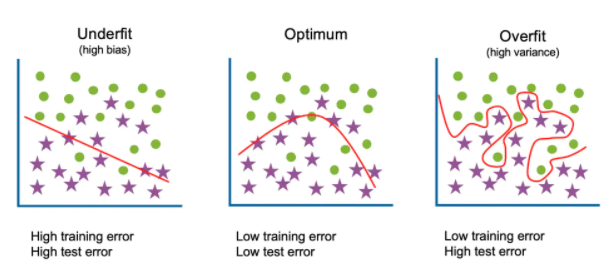

### Subajuste



Es fácil notarlo cuando tenemos un error o pérdida alta en train y validation



¿Qué hacer cuando se presenta?

- Aumentar la complejidad del modelo
- Reducir las operaciones de regularización
- Añadir características a los datos de entrenamiento
- Aumentar la duración del entrenamiento


### Sobreajuste

Es fácil notarlo cuando tenemos un error o pérdida alta en train y validation




- Añadir más datos
- Utilizar el aumento de datos
- Utilizar arquitecturas que generalicen bien
- Añadir regularización (sobre todo dropout, también es posible la regularización L1/L2)
- Reducir la complejidad de la arquitectura o realizar ensambles
- Parar anticipadamente
- Validación cruzada

# Regularización

La regularización es un proceso de introducción de información adicional para evitar el sobreajuste.


##min(J)#

Recordemos nuestra función de costo (MSE, L2)

$$J(w) = L(w) = \sum_{i=1}^{m}(h_w(x_i)- y_i)^2$$

### Regularización L1 o norma L1 Lassoo



En la regularización L1 penalizamos el valor absoluto de los pesos. El término de regularización L1 está resaltado en el recuadro rojo.
Lasso produce un modelo que es simple, interpretable y contiene un subconjunto de características de entrada

$$L_1(w) = \sum_{i=1}^{m}(h_w(x_i)- y_i)^2 + \lambda\sum_{i=1}^n |w_i|$$

En Keras:

tf.keras.regularizers.l1(l1=0.01, **kwargs)

### Regularización L2


$$L_2(w) = \sum_{i=1}^{m}(h_w(x_i)- y_i)^2 + \lambda\sum_{i=1}^n w_i^2$$

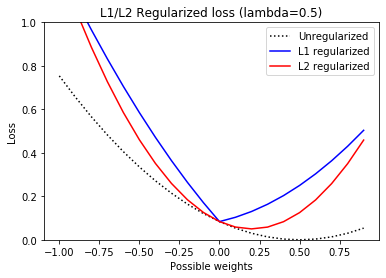

En Keras:

tf.keras.regularizers.l2(l2=0.01, **kwargs)

### Aplicando Gradiente descendente....

$$w = w - \alpha\frac{\partial L}{\partial w}$$

Calculen las derivadas de las nuevas funciones $L_1$ y $L_2$

$L$

$$w = w - \alpha 2x(h(x)- y)$$

$L_1$

$w = w - \alpha 2x(h(x)- y) + \alpha \frac{d|w|}{dw}$

$w = w - \alpha 2x(h(x)- y) + \lambda$ para $w>0$

$w = w - \alpha 2x(h(x)- y)$ - $\lambda$ para $w<0$

$L_2$

$w = w - \alpha 2x(h(x)- y) + \alpha \frac{d(w^2)}{dw}$

$w = w - \alpha 2x(h(x)- y) + 2\lambda w$

maxnorm(m):


 si la  norma $L2$ de sus pesos es superior a $m$, escale toda su matriz de pesos en un factor que reduzca la norma a $m$.




En Keras:

kernel_constraint=max_norm(3)


Decaimiento de los pesos (Weight decay)

Basada en $L_2$


$w = w - \alpha ((h(x)- y) + \lambda w$)

No está implementada en Keras

Efectos de Regularización $L_1$

Empuja $w$ hacia 0, lo anterior reduce los parámetros, por tanto reduce la complejidad del modelo.

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
(train_images, train_labels),(test_images, test_labels) = keras.datasets.fashion_mnist.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0
validation_images = train_images[:5000]
validation_labels = train_labels[:5000]

https://keras.io/api/layers/regularizers/


- kernel_regularizer: Regularizador para aplicar una penalización sobre el núcleo de la capa
- bias_regularizer: Regularizador para aplicar una penalización sobre el sesgo de la capa
- activity_regularizer: Regularizador aplicar una penalización a la salida de la capa




In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(200, activation='relu', kernel_regularizer=keras.regularizers.l1()),
    keras.layers.Dense(100, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.01)),
    keras.layers.Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.01), kernel_constraint=keras.constraints.max_norm(3)),
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 200)               157000    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                510       
Total params: 185,210
Trainable params: 185,210
Non-trainable params: 0
__________________________________________________

In [ ]:
sgd = keras.optimizers.SGD(lr=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=1, validation_data=(validation_images, validation_labels))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


1875/1875 [==============================] - 10s 5ms/step - loss: 13.7824 - accuracy: 0.5971 - val_loss: 2.2195 - val_accuracy: 0.6558


In [ ]:
model.evaluate(test_images, test_labels)


313/313 [==============================] - 1s 2ms/step - loss: 2.2461 - accuracy: 0.6387


[2.246100425720215, 0.638700008392334]

## Dropout

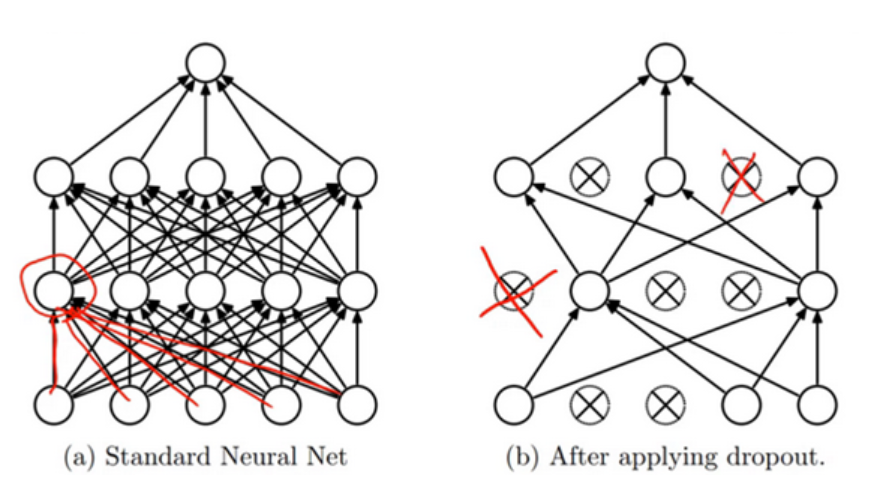

tf.keras.layers.Dropout(rate, noise_shape=None, seed=None, **kwargs)



Srivastava et al. (2014), que hablaron de Dropout en su trabajo "Dropout: A Simple Way to Prevent Neural Networks from Overfitting", encontraron empíricamente algunas mejores prácticas:

- Aunque es mejor determinar el valor del parámetro p con un conjunto de validación, está perfectamente bien establecerlo en p o rate≈0,5. Este valor ha mostrado los mejores resultados empíricos al ser probado con el conjunto de datos MNIST.
- Para evitar agujeros en los datos de entrada, no usar droput en la capa de entrada.
- Se puede utilizar cualquier optimizador. 

In [ ]:
from tensorflow import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.constraints import max_norm

In [ ]:
# Create the model
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), kernel_constraint=max_norm(2), activation='relu', input_shape=(35,35, 3), kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.50))
model.add(Conv2D(64, kernel_size=(3, 3), kernel_constraint=max_norm(2), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_constraint=max_norm(2), kernel_initializer='he_uniform'))
model.add(Dropout(0.50))
model.add(Dense(10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 33, 33, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)             

## Normalización por lotes (Batch normalization)


La normalización en lotes consiste básicamente en añadir un paso extra, habitualmente entre las neuronas y la función de activación, con la idea de normalizar las activaciones de salida. Lo ideal es que la normalización se hiciera usando la media y la varianza de todo el conjunto de entrenamiento, pero si estamos aplicando el descenso del gradiente estocástico para entrenar la red, se usará la media y la varianza de cada mini-lote de entrada.
Nota: cada salida de cada neurona se normalizará de forma independiente, lo que quiere decir que en cada iteración se calculará la media y la varianza de cada salida para el mini-lote en curso.

En Keras:

tf.keras.layers.BatchNormalization()


In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(35, 35, 3)))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 33, 33, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 33, 33, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)         

## Aumento de los datos (Data augmentation)


**### Tu red neuronal es tan buena como los datos que le das.**

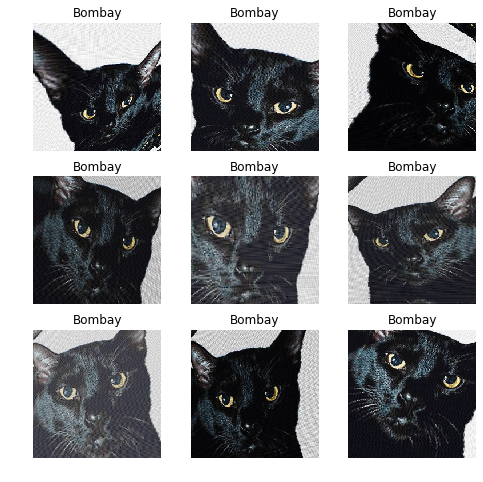

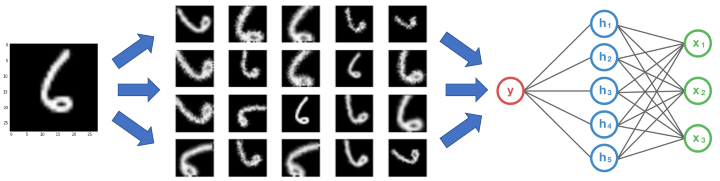

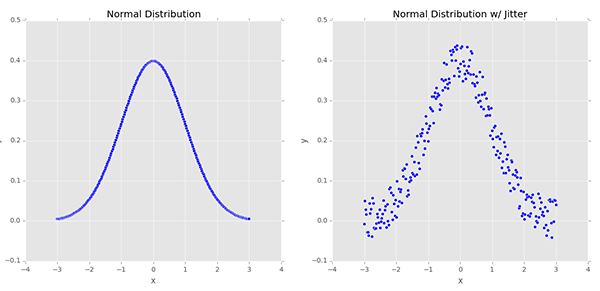

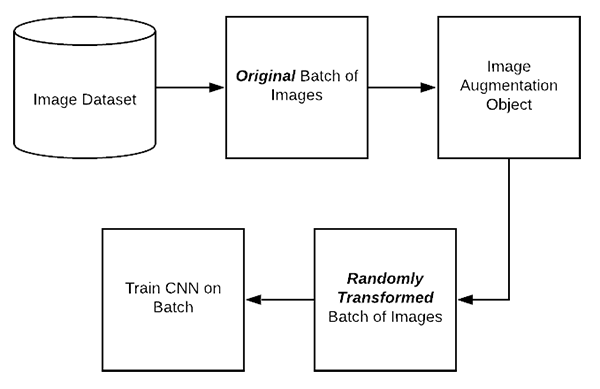

In [ ]:
from google.colab import drive
from matplotlib import pyplot as plt
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing

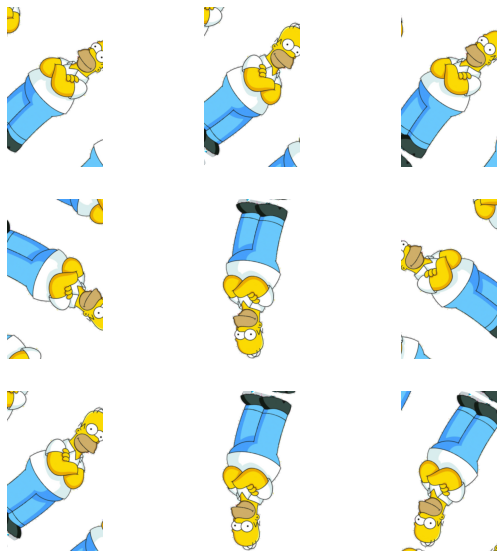

In [ ]:
import cv2

image_path  = '/content/drive/MyDrive/Colab_Notebooks/Homer_Simpson.png'

image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) / 255.0

data_augmentation = tf.keras.Sequential([
     keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     keras.layers.experimental.preprocessing.RandomRotation(0.2)])

image = tf.expand_dims(image, 0)
plt.figure(figsize=(10, 10))

for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

Podemos utilizar un generador de datos

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [ ]:
import  numpy as np

train_images = np.expand_dims(train_images, 3)


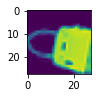

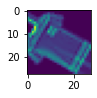

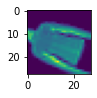

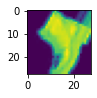

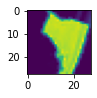

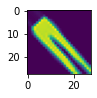

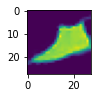

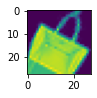

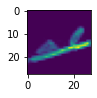

In [ ]:

datagen=keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=90,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    dtype=None,
)

datagen.fit(train_images)


for X_batch, y_batch in datagen.flow(train_images, train_labels, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(28, 28))
        plt.show()
    break

# Transferencia de aprendizaje (Transfer learning) y la puesta a punto (Fine-tuning)

El entrenamiento de una CNN desde cero es posible para proyectos pequeños, la mayoría de las aplicaciones requieren el entrenamiento de CNN muy grandes y esto requiere cantidades extremadamente grandes de datos procesados y potencia computacional.


*... el objetivo es aprovechar los datos del primer escenario para extraer información que pueda ser útil a la hora de aprender o incluso de hacer directamente predicciones en el segundo escenario.
Aunque el entrenamiento de una CNN desde cero es posible para proyectos pequeños, la mayoría de las aplicaciones requieren el entrenamiento de CNN muy grandes y esto, como has adivinado, requiere cantidades extremadamente grandes de datos procesados y potencia computacional. Y ambas cosas no se encuentran tan fácilmente hoy en día.* (Deep learning - Ian Goodfellow)


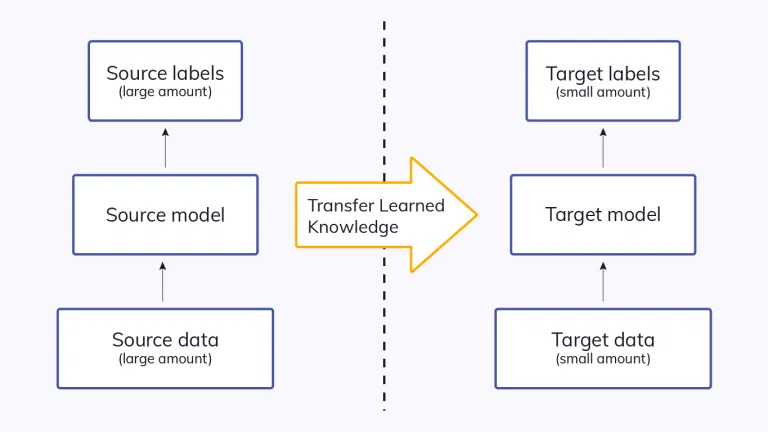

##Parada temprana (Early Stopping)


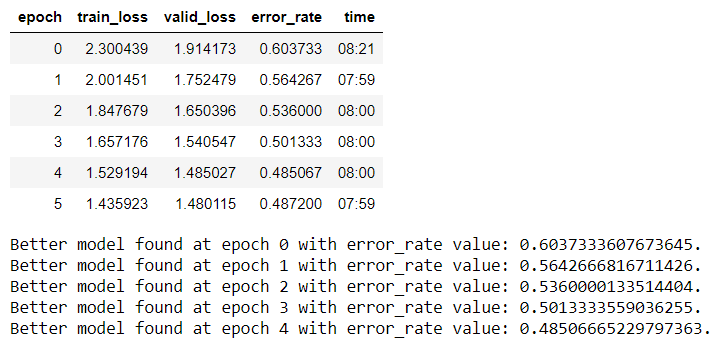

### Ventajas de la transferencia de aprendizaje

- No es necesario un conjunto de datos de entrenamiento grande.

- No se requiere mucha potencia de cálculo, ya que utilizamos pesos preentrenados y sólo tenemos que aprender los pesos de las últimas capas.